# Load and prep data

In [ ]:
!pip install pyhrv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.8/230.8 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 717.6/717.6 kB 16.8 MB/s eta 0:00:00
  Created wheel for spectrum: filename=spectrum-0.8.1-cp310-cp310-linux_x86_64.whl size=236594 sha256=e2b763ab46650c56ed33257429ea1683a389bfb7925351437379e5d0d78196dc
  Stored in directory: /root/.cache/pip/wheels/e7/5a/09/ffc6afdf8a5a6f58e9851292108df32bb11374e11b8705cabd
Successfully built spectrum


In [ ]:
!pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 29.9 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import pyhrv
import scipy
from collections import defaultdict
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# change directory to the original dataset
os.chdir('./eSports_Sensors_Dataset-master')


In [ ]:
# take a look at the files. Should be
#
# [LICENSE, 2011.00958-3.pdf,  matches, players_info.csv  README.md]
os.listdir()

['2011.00958-3.pdf',
 'HRV csvs',
 'LICENSE',
 'README.md',
 'players_info.csv',
 'matches']

In [ ]:
os.chdir('matches')

In [ ]:
"""
Necessary functions to derive data needed for analysis.
HRV function is included but we did not use this.
"""

def get_gsr(matches : dict, truncate : bool) -> dict:
    gsr_by_match_dict = defaultdict(dict)
    for match, data in matches.items():
        player_df = pd.DataFrame(columns=['player','gsr'])
        gsr_lens = []
        for player, player_data in data['players'].items():
            if 'gsr' not in list(player_data.keys()):
                print(f'{match} {player} hr missing')
                continue
            gsr_lens.append(len(player_data['gsr']))
        shortest = min(gsr_lens)
        for player, player_data in data['players'].items():
            if 'gsr' not in list(player_data.keys()):
                #print(f'match {match} {player} hr missing')
                continue
            # truncate to the shortest and collect
            if truncate:
                player_gsr = player_data['gsr'].iloc[:shortest]
            else:
                player_gsr = player_data['gsr']
            gsr_by_match_dict[match][player] = player_gsr
    return gsr_by_match_dict

def get_heart_rates(matches : dict, truncate : bool = True) -> dict:
    heart_rates_by_match_dict = {}
    for match_id, data in matches.items():
        player_df = pd.DataFrame(columns=['player','heart_rate'])
        hr_lens = []
        for player, player_data in data['players'].items():
            if 'heart_rate' not in list(player_data.keys()):
                print(f'{match_id} {player} hr missing')
                continue
            elif np.sum(player_data['heart_rate']['heart_rate'].values) <= 0.0:
                #print(match_id, player)
                print(f'{match_id} {player} hr is 0 values')
                continue
            hr_lens.append(len(player_data['heart_rate']))
        shortest = min(hr_lens)
        for player, player_data in data['players'].items():
            if 'heart_rate' not in list(player_data.keys()):
                #print(f'match {match} {player} hr missing')
                continue
            # truncate to the shortest and collect
            if truncate:
                player_name = np.array([player]*len(player_data['heart_rate']))[:shortest]
                player_hr = player_data['heart_rate']['heart_rate'].values[:shortest]
            else:
                player_name = np.array([player]*len(player_data['heart_rate']))
                player_hr = player_data['heart_rate']['heart_rate'].values
            new_df = pd.DataFrame({'player' : player_name, 'heart_rate' : player_hr})
            player_df = pd.concat([player_df,new_df])
        heart_rates_by_match_dict[match_id] = player_df
    return heart_rates_by_match_dict


def get_windowed_HRV(data : pd.DataFrame) -> pd.DataFrame:
    """
    Takes a heart-rate dataframe (of form [time, bpm]) from the player data generates
    windowed HRV values.
    """
    # converting from BPM to BPS and get the resciprocal for RR
    # time is recorded at hz
    # get nn_intervals in seconds.
    NNI_intervals = 60/data['heart_rate']
    # Generate 15 second windows
    n_windows = len(data)//15
    start = 0
    end = 15
    windowed_peaks = []
    for _ in range(n_windows):
        windowed_peaks.append(NNI_intervals[start:end])
        start = end
        end += 15
    windowed_HRV = []
    for w in windowed_peaks:
        windowed_HRV.append(pyhrv.time_domain.rmssd(nni=w)[0])
    df = pd.DataFrame(columns=['window','RMSSD'])
    df['window'] = list(range(n_windows))
    df['RMSSD'] = np.round(windowed_HRV,3)
    return df

def get_physio_data(matches : dict) -> pd.DataFrame:
    """
    Given a dictionary of matches, returns a dataframe of eeg data, HRV and GSR
    """
    players = ['player_0', 'player_1', 'player_2', 'player_3', 'player_4']

    heart_rates = get_heart_rates(matches,truncate=False)
    gsrs_by_match_dict = get_gsr(matches,truncate=False)
    hrvs_by_match_dict = defaultdict(dict)
    for m, data in heart_rates.items():
        for p in players:
            if len(data[data['player'] == p]) == 0:
                continue
            HRV = get_windowed_HRV(data[data['player'] == p])
            hrvs_by_match_dict[m][p] = HRV
    data_dict = defaultdict(lambda: defaultdict(dict))
    for match_id, match_data in matches.items():
        for d_type, match_data_values in match_data.items():
            if d_type == 'meta_info':
                data_dict[match_id]['duration']['time'] =  match_data[d_type]['match_duration']
            if d_type == 'replay':
                for replay_data_key, replay_values in match_data_values.items():
                    if 'player' in replay_data_key and matches[match_id]['replay'][replay_data_key]['teamName'] == 'participants':
                        data_dict[match_id][replay_data_key]['death_times'] = replay_values['deathTimes']
                        data_dict[match_id][replay_data_key]['kill_times'] = replay_values['killTimes']
                        data_dict[match_id][replay_data_key]['assist_times'] = replay_values['assistTimes']
            if d_type == 'players':
                for player, player_data_values in match_data_values.items():
                    #print(player, player_data_values.keys())
                    if 'eeg_band_power' in player_data_values.keys():
                        data_dict[match_id][player]['eeg_power'] = player_data_values['eeg_band_power']
                        data_dict[match_id][player]['eeg_metrics'] = player_data_values['eeg_metrics']
                        data_dict[match_id][player]['hrv'] = hrvs_by_match_dict[match_id][player]
                        data_dict[match_id][player]['gsr'] = gsrs_by_match_dict[match_id][player]
                        data_dict[match_id][player]['player_report'] = player_data_values['player_report']
                        data_dict[match_id][player]['heart_rate'] = heart_rates[match_id][heart_rates[match_id]['player'] == player]
                    elif player in data_dict[match_id]:
                        print(f'eeg missing for player {player} in match {match_id}')
                        del data_dict[match_id][player]
    return(data_dict)

In [ ]:
# Loads a pickle of the loaded match CSVS and reading the CSVs takes some time
import pickle
with open('loaded_matches.pickle', 'rb') as file:

    # Call load method to deserialze
    matches = pickle.load(file)

    #print(matches)

# Initial idea : Bots vs Real players (running this section can be safely skipped)

This section corressponds to the our intial idea of designating bots as the low workload condition matches and real as the high workload condition matches.


In [ ]:
# designate bot matches as low workload
lw_matches = ['match_0','match_12','match_15','match_17','match_19','match_2','match_21','match_4','match_6','match_9']

In [ ]:
hw_matches = {}
for m in matches:
  if m not in lw_matches:
    hw_matches[m] = matches[m]

In [ ]:
lw_match_data = {i : matches[i] for i in lw_matches}

In [ ]:
hw_match_data = {i : matches[i] for i in hw_matches}

In [ ]:
# match count
print(f'low work load : {len(lw_matches)}')
print(f'high work load : {len(hw_matches)}')


In [ ]:
lw_phys_data = get_physio_data(lw_match_data)
hw_phys_data = get_physio_data(hw_match_data)

In [ ]:
vars = ['eeg_power', 'gsr', 'heart_rate']
lw_data_shape_info = defaultdict(lambda: defaultdict(dict))
for match_id in lw_phys_data:
    for player in lw_phys_data[match_id]:
        if player != 'duration':
          for signal in lw_phys_data[match_id][player]:
            if signal in vars:
              lw_data_shape_info[match_id][player][signal] = lw_phys_data[match_id][player][signal].shape


In [ ]:
# Transform the dictionary to a list of tuples suitable for DataFrame conversion
data_tuples = []
for match_id, players in lw_data_shape_info.items():
    for player, signals in players.items():
        for signal, shape in signals.items():
            data_tuples.append((match_id, player, signal, shape))

# Create a DataFrame with MultiIndex from the tuples
lw_df = pd.DataFrame(data_tuples, columns=['Match_ID', 'Player', 'Signal', 'Shape'])


In [ ]:
vars = ['eeg_power', 'gsr', 'heart_rate']
hw_data_shape_info = defaultdict(lambda: defaultdict(dict))
for match_id in hw_phys_data:
    for player in hw_phys_data[match_id]:
        if player != 'duration':
          for signal in hw_phys_data[match_id][player]:
            if signal in vars:
              hw_data_shape_info[match_id][player][signal] = hw_phys_data[match_id][player][signal].shape

# Transform the dictionary to a list of tuples suitable for DataFrame conversion
data_tuples = []
for match_id, players in hw_data_shape_info.items():
    for player, signals in players.items():
        for signal, shape in signals.items():
            data_tuples.append((match_id, player, signal, shape))

# Create a DataFrame with MultiIndex from the tuples
hw_df = pd.DataFrame(data_tuples, columns=['Match_ID', 'Player', 'Signal', 'Shape'])

In [ ]:
hw_df.tail(7)

In [ ]:
# check differences in GSR levels between conditions
hw_pro_mean_gsrs = []
hw_amateur_mean_gsrs = []
for match_id in hw_matches:
  #print(hw_match_data[match_id].keys())
  for player in hw_match_data[match_id]['players']:
    if hw_match_data[match_id]['meta_info']['team'] == 'pros':
      hw_pro_mean_gsrs.append(np.mean(hw_match_data[match_id]['players'][player]['gsr']['gsr'].values))
    else:
      hw_amateur_mean_gsrs.append(np.mean(hw_match_data[match_id]['players'][player]['gsr']['gsr'].values))
print(np.mean(hw_pro_mean_gsrs), np.std(hw_pro_mean_gsrs))
print(np.mean(hw_amateur_mean_gsrs), np.std(hw_amateur_mean_gsrs))

In [ ]:
import matplotlib.pyplot as plt
plt.boxplot([hw_pro_mean_gsrs,hw_amateur_mean_gsrs])

In [ ]:
# check differences in GSR levels between conditions
lw_pro_mean_gsrs = []
lw_amateur_mean_gsrs = []
for match_id in lw_matches:
  #print(hw_match_data[match_id].keys())
  for player in lw_match_data[match_id]['players']:
    #print(lw_match_data[match_id]['meta_info']['team'])
    if lw_match_data[match_id]['meta_info']['team'] == 'pros':
      lw_pro_mean_gsrs.append(np.mean(lw_match_data[match_id]['players'][player]['gsr']['gsr'].values))
    else:
      lw_amateur_mean_gsrs.append(np.mean(lw_match_data[match_id]['players'][player]['gsr']['gsr'].values))

print(np.mean(lw_pro_mean_gsrs), np.std(lw_pro_mean_gsrs))
print(np.mean(lw_amateur_mean_gsrs), np.std(lw_amateur_mean_gsrs))

## Windowing (relevant sections of code)

This section corressponds to the generation of the datat was used : designating a time window around kills, deaths, and assists as the highworkload condition

# All physio signals : windowing around significant events

In [ ]:
all_signals = get_physio_data(matches)

match_0 player_2 hr missing
match_1 player_2 hr missing
match_14 player_3 hr missing
match_15 player_0 hr missing
match_15 player_3 hr missing
match_16 player_3 hr missing
match_17 player_3 hr missing
match_18 player_4 hr is 0 values
match_19 player_4 hr missing
match_2 player_2 hr missing
match_20 player_4 hr is 0 values
match_21 player_4 hr is 0 values
match_3 player_0 hr missing
match_3 player_2 hr missing
match_7 player_2 hr missing
match_8 player_2 hr missing
eeg missing for player player_0 in match match_0
eeg missing for player player_2 in match match_0
eeg missing for player player_3 in match match_0
eeg missing for player player_4 in match match_0
eeg missing for player player_0 in match match_1
eeg missing for player player_2 in match match_1
eeg missing for player player_3 in match match_1
eeg missing for player player_4 in match match_1
eeg missing for player player_0 in match match_10
eeg missing for player player_1 in match match_10
eeg missing for player player_2 in matc

In [ ]:
# check which players in which matches are available for analysis
for match_id in all_signals.keys():
  if len(list(all_signals[match_id].keys())) == 0:
    continue
  print(match_id, list(all_signals[match_id].keys())[1:])


match_0 ['player_1']
match_1 ['player_1']
match_10 ['player_3', 'player_4']
match_11 ['player_1', 'player_2', 'player_3', 'player_4']
match_12 ['player_1', 'player_2', 'player_3', 'player_4']
match_13 ['player_1', 'player_2', 'player_3', 'player_4']
match_14 ['player_1', 'player_2', 'player_4']
match_15 []
match_16 []
match_17 []
match_18 ['player_1', 'player_2']
match_19 ['player_1', 'player_2']
match_2 ['player_1']
match_20 ['player_1', 'player_2']
match_21 ['player_1', 'player_2', 'player_3']
match_3 ['player_1']
match_4 []
match_5 []
match_6 []
match_7 []
match_8 ['player_3', 'player_4']
match_9 ['player_3', 'player_4']


In [ ]:
import seaborn as sns
from PIL import Image
pd.options.mode.chained_assignment = None
np.random.seed(42)


def get_windows(player : dict,  time_delta : int = 4, under_sample : bool = True) -> dict:
  """
  args:
    player      : A dictionary containing information about a player, including physiological signals and event times
    mois        : list of lists (kills, deaths, assists)
    time_delta  : Window to consider around moment
                  set time window detault as 4 based https://link.springer.com/article/10.1007/s41060-024-00529-6

  Given a physiological signal from a player (signal) and a dictionary of moments of interest (mois)
  Generates two pieces of information:

  1. From a physiological signal for a given player (e.g., GSR), extracts windows of length moment of interest +- time_delta
  where moments of intetersfet (moi) are kills, deaths, and assits of a given player. These are high-workload time segments.
  2. Takes the remaining sections of the physiological sections as the negative class.
     Optionally undersample the negative class to keep the training data balanced
  """
  import itertools
  from collections import defaultdict
  # The signals must be cut to be the same size.
  # All signals should be as longa s EEG signal. If EEG is longer, should be truncated to smallest signal availabe
  eeg_length = player['eeg_power'].shape[0]
  hr_length = player['heart_rate'].shape[0]
  gsr_length = player['gsr'].shape[0]
  smallest_length = np.min(np.array([eeg_length, hr_length,gsr_length]))

  eeg_truncated = player['eeg_power'].iloc[:smallest_length]
  gsr_truncated = player['gsr'].iloc[0:smallest_length]
  heart_rate_truncated = player['heart_rate'].iloc[0:smallest_length]

  # Subtract the mean value of signal from each player. The reasoning here is that each
  # player may have a different baseline level of activation for each of these signals

  eeg_mean = np.mean(eeg_truncated.iloc[:,1:], axis = 0)
  gsr_mean = np.mean(gsr_truncated['gsr'])
  heart_rate_mean = np.mean(heart_rate_truncated['heart_rate'])

  # subtract the means
  eeg_cols = eeg_truncated.columns[1:]
  eeg_truncated[list(eeg_cols)] = eeg_truncated[list(eeg_cols)] - eeg_mean
  heart_rate_truncated['heart_rate'] = heart_rate_truncated['heart_rate'] - heart_rate_mean
  gsr_truncated['gsr'] = gsr_truncated['gsr'] - gsr_mean


  max_time = eeg_truncated['time'].iloc[-1]
  # make sure that the moments of interest are within the bounds for generating a window
  d_times_array = [v for v in player['death_times'] if ((v < max_time - time_delta) and (v > time_delta))]
  k_times_array =  [v for v in player['kill_times'] if ((v < max_time - time_delta) and (v > time_delta))]
  a_times_array =  [v for v in player['assist_times'] if ((v < max_time - time_delta) and (v > time_delta))]
  mois = [d_times_array,k_times_array,a_times_array]

  # flatten the list and round the time to the nearest integer for indexing time
  events = np.int16(np.round(list(itertools.chain(*mois))))

  positive_class = {'eeg' : None, 'gsr' : None, 'hr' : None}
  negative_class = {'eeg' : None, 'gsr' : None, 'hr' : None}

  pos_gsr_windows = []
  pos_eeg_windows = []
  pos_heart_rate_windows = []
  windows = []
  # sample windows around events (positive class)
  for event_time in events:
    # make sure the events have sufficient distance around them to be windowed
    if (event_time < (eeg_length - time_delta)) and (event_time > (time_delta)):
      t_plus_delta = event_time + time_delta
      t_minus_delta = event_time - time_delta
      window = [t_minus_delta, t_plus_delta]
      gsr_feature = gsr_truncated.iloc[window[0]:window[1]].drop(columns=['time'])
      eeg_feature = eeg_truncated.iloc[window[0]:window[1]].drop(columns=['time'])
      heart_rate_feature = heart_rate_truncated.iloc[window[0]:window[1]]
      pos_gsr_windows.append(gsr_feature)
      pos_eeg_windows.append(eeg_feature)
      pos_heart_rate_windows.append(heart_rate_feature)
      windows.append(window)

  positive_class['eeg'] = pos_eeg_windows
  positive_class['gsr'] = pos_gsr_windows
  positive_class['hr']  = pos_heart_rate_windows
  indexes = np.array(np.arange(eeg_length))
  for window in windows:
    mask = np.arange(window[0],window[1])
    np.put(indexes,mask,-1)

  negative_samples = []
  if under_sample:
    while len(negative_samples) < len(pos_eeg_windows):
      # get a random integer starting away from the start and end to avoid sampling windows outside of the indices
      random_index = np.random.randint(time_delta,eeg_length - time_delta + 1)
      random_window = np.arange(random_index - time_delta, random_index + time_delta)
      random_window = indexes[random_window]
      # keep sampling until arrays without positive samples are generated
      if -1 not in random_window:
        negative_samples.append(random_window)

  neg_gsr_windows = []
  neg_eeg_windows = []
  neg_heart_rate_windows = []
  try:
    for n_window in negative_samples:
      gsr_feature = gsr_truncated.drop(columns=['time'])
      eeg_feature = eeg_truncated.drop(columns=['time'])
      heart_rate_feature = heart_rate_truncated
      neg_gsr_windows.append(gsr_feature.iloc[n_window])
      neg_eeg_windows.append(eeg_feature.iloc[n_window])
      neg_heart_rate_windows.append(heart_rate_feature.iloc[n_window])
  except IndexError:
    print(f"Index for negative sample {n_window} out of bounds in one of :  \ngsr : {player['heart_rate'].shape} \nheart rate : {player['heart_rate'].shape}")

  negative_class['eeg'] = neg_eeg_windows
  negative_class['gsr'] = neg_gsr_windows
  negative_class['hr']  = neg_heart_rate_windows
  return (positive_class, negative_class)

def eeg_to_image(data: list, dir_path: str, _class: str, eeg_combined_array, label: str) -> None:
    """
    Given a list of EEG frequency-time dataframes, generates a heat map image of each dataframe. And standardizes the data.
    """
    #Getting metrics for normalization
    mean = eeg_combined_array.mean(axis=(0,1))
    std = eeg_combined_array.std(axis=(0,1))
    min = eeg_combined_array.min(axis=(0,1))
    max = eeg_combined_array.max(axis=(0,1))
    median = np.median(eeg_combined_array, axis=(0,1))
    quantile25 = np.quantile(eeg_combined_array, 0.25, axis=(0,1))
    quantile75 = np.quantile(eeg_combined_array, 0.75, axis=(0,1))
    iqr = quantile75 - quantile25

    # Define the desired frequency order
    frequency_order = ['theta', 'alpha', 'betaL', 'betaH', 'gamma']
    
    for i, player in enumerate(data):
        for j, event in enumerate(player):
            columns = event.columns

            # Create a sorted list of columns based on the frequency_order
            sorted_columns = [col for freq in frequency_order for col in columns if freq in col]

            # Reorder the dataframe columns using the sorted list so that the data is sorted by frequency band (alpha to Gamma)
            event = event[sorted_columns]

            np_array = event.to_numpy()

            #Robust scaler
            np_array_robust = (np_array - median)/iqr
            np_array_robust_T = np_array_robust.T

            im = Image.fromarray(np_array_robust_T)
            im = im.convert("L")
            im.save(f'{dir_path}/{_class}/img_match{i}_event_{j}.png',"PNG")



In [ ]:
# Generate positive and negative classes
# Ignore the out of bounds warning printed

positive_class = []
negative_class = []
for match_id in all_signals:
  for player in all_signals[match_id]:
    if 'eeg_power' in all_signals[match_id][player].keys():
      train_data = get_windows(all_signals[match_id][player],time_delta = 4,under_sample = True)
      if len(train_data[0]['eeg']) == 0:
        continue
      positive_class.append(train_data[0])
      negative_class.append(train_data[1])

In [ ]:
# Testing to make sure everything is the same even if you run it seperately multiple times
positive_class_test = []
negative_class_test = []
for match_id in all_signals:
  for player in all_signals[match_id]:
    if 'eeg_power' in all_signals[match_id][player].keys():
      train_data = get_windows(all_signals[match_id][player],time_delta = 4,under_sample = True)
      if len(train_data[0]['eeg']) == 0:
        continue
      positive_class_test.append(train_data[0])
      negative_class_test.append(train_data[1])

# Prints fout if something is off
for i, match_player in enumerate(positive_class_test):
  for sig in ['eeg','gsr','hr']:
    for j, ex in enumerate(match_player[sig]):
      if sig == 'hr':
        if not np.allclose(ex['heart_rate'].values,positive_class[i][sig][j]['heart_rate'].values):
          print('fout!')
      else:
        if not np.allclose(ex.to_numpy(),positive_class[i][sig][j].to_numpy()):
          print('fout!')


Index for negative sample [2198 2199 2200 2201 2202 2203 2204 2205] out of bounds in one of :  
gsr : (2160, 2) 
heart rate : (2160, 2)


In [ ]:
# check the number of positive samples generated
signals = ['eeg', 'gsr', 'hr']
pos_total = {'eeg' : 0, 'gsr' : 0, 'hr' : 0}
for match_player in positive_class:
  pos_total['eeg'] += len(match_player['eeg'])
  pos_total['gsr'] += len(match_player['gsr'])
  pos_total['hr'] += len(match_player['hr'])
pos_total

{'eeg': 637, 'gsr': 637, 'hr': 637}

In [ ]:
# check the number of negative samples generated
neg_total = {'eeg' : 0, 'gsr' : 0, 'hr' : 0}
for match_player in negative_class:
  #print(k, len(positive_class[0][k]))
  neg_total['eeg'] += len(match_player['eeg'])
  neg_total['gsr'] += len(match_player['gsr'])
  neg_total['hr'] += len(match_player['hr'])
neg_total

{'eeg': 637, 'gsr': 637, 'hr': 637}

In [ ]:
# Generate a combined dataset with both classes
eeg_combined = []
for c in [positive_class,negative_class]:
  for i in c:
    for j in i['eeg']:
      eeg_combined.append(j)
eeg_combined_array = np.array(eeg_combined)

### Generate min, max, mean EEG band activation features (https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9278704)

In [ ]:
cols = list(eeg_combined[0].columns)

In [ ]:
# min-max scaling
mean = eeg_combined_array.mean(axis=(0,1))
std = eeg_combined_array.std(axis=(0,1))
min = eeg_combined_array.min(axis=(0,1))
max = eeg_combined_array.max(axis=(0,1))
median = np.median(eeg_combined_array, axis=(0,1))
quantile25 = np.quantile(eeg_combined_array, 0.25, axis=(0,1))
quantile75 = np.quantile(eeg_combined_array, 0.75, axis=(0,1))
iqr = quantile75 - quantile25

bands = ['theta','alpha','betaL','betaH','gamma']
group_bands = []
for b in bands:
  l = []
  for c in cols:
    if b in c:
      l.append(c)
  group_bands.append(l)

positive_new_features = []
for collection in positive_class:
  for example in collection['eeg']:
    ex_features = []
    example = (example - median)/iqr
    for band in group_bands:
      band_i = example[band].values.flatten()
      band_mean = np.mean(band_i)
      band_max = np.max(band_i)
      band_min = np.min(band_i)
      ex_features.extend([band_mean,band_max,band_min])
    positive_new_features.append(ex_features)
positive_new_features = np.array(positive_new_features)

negative_new_features = []
for collection in negative_class:
  for example in collection['eeg']:
    ex_features = []
    example = (example - median)/iqr
    for band in group_bands:
      band_i = example[band].values.flatten()
      band_mean = np.mean(band_i)
      band_max = np.max(band_i)
      band_min = np.min(band_i)
      ex_features.extend([band_mean,band_max,band_min])
    negative_new_features.append(ex_features)
negative_new_features = np.array(negative_new_features)


np.savetxt("all_combined/positive_eeg.csv", positive_new_features, delimiter=",")
np.savetxt("all_combined/negative_eeg.csv", negative_new_features, delimiter=",")

In [ ]:
# check the sizes. Should match pos_total and neg_total
print(positive_new_features.shape, negative_new_features.shape)
print(positive_new_features.shape[0] == pos_total['eeg'])
print(negative_new_features.shape[0] == neg_total['eeg'])

(637, 15) (637, 15)
True
True


## Generate positive class files

In [ ]:
# sanity checks for file generation
print('n files in folder before: ')
len(os.listdir('all_combined/eeg_images/positive_class'))

n files in folder before: 


0

In [ ]:
X_eeg = []
X_gsr = []
X_hr = []
# class is a list of dictionaries
for sample in positive_class:
  for signal in sample:
    #print(signal, len(sample[signal]))
    if signal == 'eeg':
      X_eeg.append(sample[signal])
    if signal == 'gsr':
      X_gsr.append(sample[signal])
    if signal == 'hr':
      X_hr.append(sample[signal])

path = 'all_combined/eeg_images'

_class = 'positive_class'
eeg_to_image(X_eeg,path,_class,eeg_combined_array,"positive")

In [ ]:
print('n files in folder after, should match pos_total for EEG: ')
print(pos_total['eeg'])
len(os.listdir('all_combined/eeg_images/positive_class'))

n files in folder after, should match pos_total for EEG: 
637


637

In [ ]:
import matplotlib.pyplot as plt
import mne
import numpy as np


def plot_topomaps(df : pd.DataFrame, bands : list):
    """
    Given a dataframe of shape (time steps x channels) generates a topological map of activation at each sensor at each time step.
    args : 
        df      : A pandas DataFrame containing activation for t time steps (rows) in n channels (columns). Supposing 5 channels and 5 frequency bands,
                  this df will have 25 columns where each column represents the activity for a given band at that channel (i.e., sensor)
        bands   : A list of relevant frequency bands (e.g, alpha, beta, theta)
    """
    electrodes = ['AF3', 'T7', 'Pz', 'T8', 'AF4']
    num_time_points = 8  # Total number of time points

    # Create a figure with subplots - one for each band and time point
    fig, axes = plt.subplots(nrows=num_time_points, ncols=len(bands), figsize=(20, 20)) # Adjust figsize as needed
    plt.subplots_adjust(hspace = 0.0001, wspace = 0.0001)
    for col, band in enumerate(bands):
        for row in range(num_time_points):
            data = df.loc[row, [f"{electrode}/{band}" for electrode in electrodes]].values

            # Create an info structure for MNE with standard 10-20 positions
            montage = mne.channels.make_standard_montage('standard_1020')
            info = mne.create_info(ch_names=electrodes, sfreq=1, ch_types='eeg')
            info.set_montage(montage)

            # Create an EvokedArray with the data
            evoked = mne.EvokedArray(data[:, np.newaxis], info)

            # Plot the topomap on the specified subplot
            ax = axes[row, col]
            im, cn = mne.viz.plot_topomap(evoked.data[:, 0], evoked.info, axes=ax, show=False, sensors='g+', names=electrodes)

            # Increase font size of sensor names and size of markers
            for text in ax.texts:
                text.set_fontsize(15)  # Adjust text size here
            for line in ax.lines:
                line.set_markersize(20)  # Adjust marker size here

    # Set the labels for the bands at the bottom of each column
    for ax, band in zip(axes[-1], bands):
        ax.set_xlabel(band, fontsize=14)

    # Label y-axis with time points
    for ax, time_point in zip(axes[:, 0], range(num_time_points)):
        ax.set_ylabel(f'Time Point {time_point}', fontsize=14)

    # Add overall x and y axis labels
    fig.text(0.5, -0.01, 'Frequency Band', ha='center', va='center', fontsize=16)
    fig.text(0.02, 0.5, 'Time Point', ha='center', va='center', rotation='vertical', fontsize=16)

    plt.tight_layout(pad=3.0)  # Increase padding to prevent overlap
    plt.show()

In [ ]:
# Get the average band wise activuation for the positive class per channel
# min-max scaling
mean = eeg_combined_array.mean(axis=(0,1))
std = eeg_combined_array.std(axis=(0,1))
min = eeg_combined_array.min(axis=(0,1))
max = eeg_combined_array.max(axis=(0,1))
median = np.median(eeg_combined_array, axis=(0,1))
quantile25 = np.quantile(eeg_combined_array, 0.25, axis=(0,1))
quantile75 = np.quantile(eeg_combined_array, 0.75, axis=(0,1))
iqr = quantile75 - quantile25
original_columns = list(eeg_combined[0].columns)

ctr = 0
accumulate = np.zeros((8,25))
for i in positive_class:
  for example in i['eeg']:
    # scaling
    example = (example - median)/iqr
    accumulate += example.to_numpy()
    ctr += 1

accumulate = accumulate / ctr
accumulate_1 = pd.DataFrame(accumulate, columns = original_columns)
print(accumulate)


[[-0.14943459 -0.19861914  0.07390748  1.8505917   2.14802475  0.57251163
   1.07830096  1.15122754  2.81388078  2.28211117 -0.58629483 -0.16464612
  -0.09156736  0.52095075  0.99373746  0.70160451  1.1890768   1.13838939
   2.51869703  2.52970543 -0.27174366 -0.31385318  0.24915712  2.194143
   2.37460921]
 [ 0.04245366 -0.04289248  0.59554901  1.40130326  1.91250632  0.7461405
   1.51792924  1.85334646  2.44298142  2.11359798 -0.43227989 -0.13505682
  -0.0314232   0.44281638  0.90531996  0.75486348  1.43049303  1.39748854
   2.01886165  2.58638532 -0.08973218 -0.13508555  0.64083909  1.75610477
   2.3045434 ]
 [ 0.02500749 -0.09829646  0.58599158  1.54077327  2.05108063  0.81588971
   1.31410059  2.10533763  2.13823781  2.290842   -0.15658322 -0.04897736
   0.1513055   0.33302645  0.81047661  0.76628182  1.58635881  1.74208014
   2.09532131  2.21758091 -0.14550799 -0.26410744  0.57065774  1.40302091
   2.03355671]
 [ 0.00341971 -0.10136157  0.24730482  1.22042392  1.81597752  0.73766

In [ ]:
# Plot the average activation 
plot_topomaps(accumulate,bands)

In [ ]:
# Get the average band wise activuation for the negative class
# min-max scaling
mean = eeg_combined_array.mean(axis=(0,1))
std = eeg_combined_array.std(axis=(0,1))
min = eeg_combined_array.min(axis=(0,1))
max = eeg_combined_array.max(axis=(0,1))
median = np.median(eeg_combined_array, axis=(0,1))
quantile25 = np.quantile(eeg_combined_array, 0.25, axis=(0,1))
quantile75 = np.quantile(eeg_combined_array, 0.75, axis=(0,1))
iqr = quantile75 - quantile25
original_columns = list(eeg_combined[0].columns)

ctr = 0
accumulate = np.zeros((8,25))
for i in negative_class:
  for example in i['eeg']:
    # scaling
    example = (example - median)/iqr
    accumulate += example.to_numpy()
    ctr += 1

accumulate = accumulate / ctr
accumulate_2 = pd.DataFrame(accumulate, columns = original_columns)
print(accumulate)

[[ 0.88377525  1.10768197  0.59267233  1.22342404  0.43513102  0.05147921
   0.15544276 -0.07763171  0.13696925 -0.1512914   0.96395243  0.31106101
   0.22455076  0.36479051  0.22136988 -0.13189243 -0.41627039 -1.53419943
  -0.02858217 -0.67532964  0.95870376  1.26734545  0.17034001  1.43067544
   0.25132378]
 [ 1.24471693  1.4208228   0.58548742  1.20856213  0.1320238   0.26791938
   0.33586798 -0.17300754  0.21053371 -0.34752561  1.09223233  0.34759865
   0.33870425  0.40129463  0.03725628 -0.12088062  0.01628527 -1.52805725
  -0.14776275 -0.86459896  1.37290185  1.63018143  0.55565724  1.46279662
   0.12408691]
 [ 1.40242122  1.80986845  1.02468677  1.45627194  0.39238437  0.37623068
   0.73869386  0.00927981  0.09959153 -0.06475089  1.02169294  0.36154517
   0.5182383   0.44749587  0.08979022 -0.10769453  0.09557279 -1.10107783
  -0.24528568 -0.65538508  1.59188015  1.98702713  0.94341726  1.63646954
   0.27682211]
 [ 1.34466294  1.89740404  1.25142263  1.96396569  0.27340509  0.30

In [ ]:
plot_topomaps(accumulate,bands)

In [ ]:
print('n files in folder before: ')
len(os.listdir('all_combined/gsr/positive_class'))

n files in folder before: 


0

In [ ]:
for i,dat in enumerate(X_gsr):
  #print(len(i))
  for j, df in enumerate(dat):
    df = df.reset_index(drop = True).T
    #/Users/udeshhabaraduwa/Library/CloudStorage/GoogleDrive-u.habaraduwakandambige@tilburguniversity.edu/Mijn Drive/
    df.to_csv(f'all_combined/gsr/positive_class/match_{i}_event_{j}.csv')

In [ ]:
print('n files in folder after, should match pos_total for GSR: ')
print(pos_total['gsr'])
len(os.listdir('all_combined/gsr/positive_class/'))

n files in folder after, should match pos_total for GSR: 
637


637

In [ ]:
print('n files in folder before: ')
len(os.listdir('all_combined/hr/positive_class'))

n files in folder before: 


0

In [ ]:
for i,dat in enumerate(X_hr):
  for j, df in enumerate(dat):
    hr_vals = pd.DataFrame(df['heart_rate'].reset_index(drop = True)).T
    hr_vals.to_csv(f'all_combined/hr/positive_class/match_{i}_event_{j}.csv')

In [ ]:
print('n files in folder after, should match pos_total for HR: ')
print(pos_total['hr'])
len(os.listdir('all_combined/hr/positive_class/'))

n files in folder after, should match pos_total for HR: 
637


637

## Generate the negative class files

In [ ]:
print('n files in folder before: ')
len(os.listdir('all_combined/eeg_images/negative_class'))


n files in folder before: 


0

In [ ]:
X_eeg = []
X_gsr = []
X_hr = []
# class is a list of dictionaries
for sample in negative_class:
  for signal in sample:
    #print(signal, len(sample[signal]))
    if signal == 'eeg':
      X_eeg.append(sample[signal])
    if signal == 'gsr':
      X_gsr.append(sample[signal])
    if signal == 'hr':
      X_hr.append(sample[signal])

path = 'all_combined/eeg_images'

_class = 'negative_class'
eeg_to_image(X_eeg,path,_class,eeg_combined_array,"negative")

In [ ]:
print('n files in folder after, should match neg_total for EEG: ')
print(neg_total['eeg'])
len(os.listdir('all_combined/eeg_images/negative_class/'))

n files in folder after, should match neg_total for EEG: 
637


637

In [ ]:
print('n files in folder before: ')
len(os.listdir('all_combined/gsr/negative_class'))

n files in folder before: 


0

In [ ]:
for i,dat in enumerate(X_gsr):
  for j, df in enumerate(dat):
    df = df.reset_index(drop = True).T
    df.to_csv(f'all_combined/gsr/negative_class/match_{i}_event_{j}.csv')

In [ ]:
print('n files in folder after, should match neg_total for gsr: ')
print(neg_total['gsr'])
len(os.listdir('all_combined/gsr/negative_class/'))

n files in folder after, should match neg_total for gsr: 
637


637

In [ ]:
print('n files in folder before: ')
len(os.listdir('all_combined/hr/negative_class'))

n files in folder before: 


0

In [ ]:
for i,dat in enumerate(X_hr):
  for j, df in enumerate(dat):
    hr_vals = pd.DataFrame(df['heart_rate'].reset_index(drop = True)).T
    hr_vals.to_csv(f'all_combined/hr/negative_class/match_{i}_event_{j}.csv')

In [ ]:
print('n files in folder after, should match neg_total for hr: ')
print(neg_total['hr'])
len(os.listdir('all_combined/hr/negative_class/'))

n files in folder after, should match neg_total for hr: 
637


637

## Example windows

In [ ]:
d_times_array = all_signals['match_10']['player_3']['death_times']
k_times_array = all_signals['match_10']['player_3']['kill_times']
a_times_array = all_signals['match_10']['player_3']['assist_times']
closest_indices_dtimes = [np.abs(all_signals['match_10']['player_3']['gsr']['time'] - time).argmin() for time in d_times_array]
closest_indices_ktimes = [np.abs(all_signals['match_10']['player_3']['gsr']['time'] - time).argmin() for time in k_times_array]
closest_indices_atimes = [np.abs(all_signals['match_10']['player_3']['gsr']['time'] - time).argmin() for time in a_times_array]

In [ ]:
d_times_array

[718.026, 919.011, 1000.43, 1125.558, 1320.2, 1360.205]

In [ ]:
closest_indices_dtimes

[718, 919, 1000, 1126, 1320, 1360]

In [ ]:
all_signals['match_1'].keys()

dict_keys(['duration', 'player_1'])

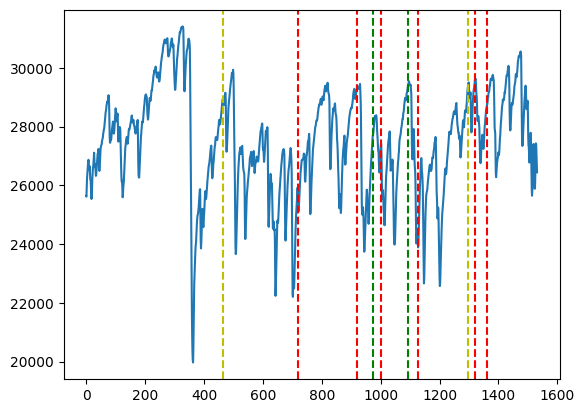

In [ ]:
event_list = [closest_indices_dtimes,closest_indices_ktimes,closest_indices_atimes]
plt.plot(all_signals['match_1']['player_1']['gsr']['gsr'].values)
colors = ['r','g','y']
for i,event in enumerate(event_list):
  for time in event:
      plt.axvline(x=time, color=colors[i], linestyle='--',)

In [ ]:
# set time window t = 4 based https://link.springer.com/article/10.1007/s41060-024-00529-6
delta = 8
dtimes_windows = []
for t in d_times_array:
  t_plus_delta = t + delta
  t_plus_delta_index = np.abs(all_signals['match_10']['player_3']['gsr']['time'] - t_plus_delta).argmin()
  t_minus_delta = t - delta
  t_minus_delta_index = np.abs(all_signals['match_10']['player_3']['gsr']['time'] - t_minus_delta).argmin()
  window = [t_minus_delta_index, t_plus_delta_index]
  dtimes_windows.append(window)


In [ ]:
closest_indices_dtimes

[718, 919, 1000, 1126, 1320, 1360]

In [ ]:
dtimes_windows

[[710, 726], [911, 927], [992, 1008], [1118, 1134], [1312, 1328], [1352, 1368]]

Text(0, 0.5, 'GSR ($\\Omega$)')

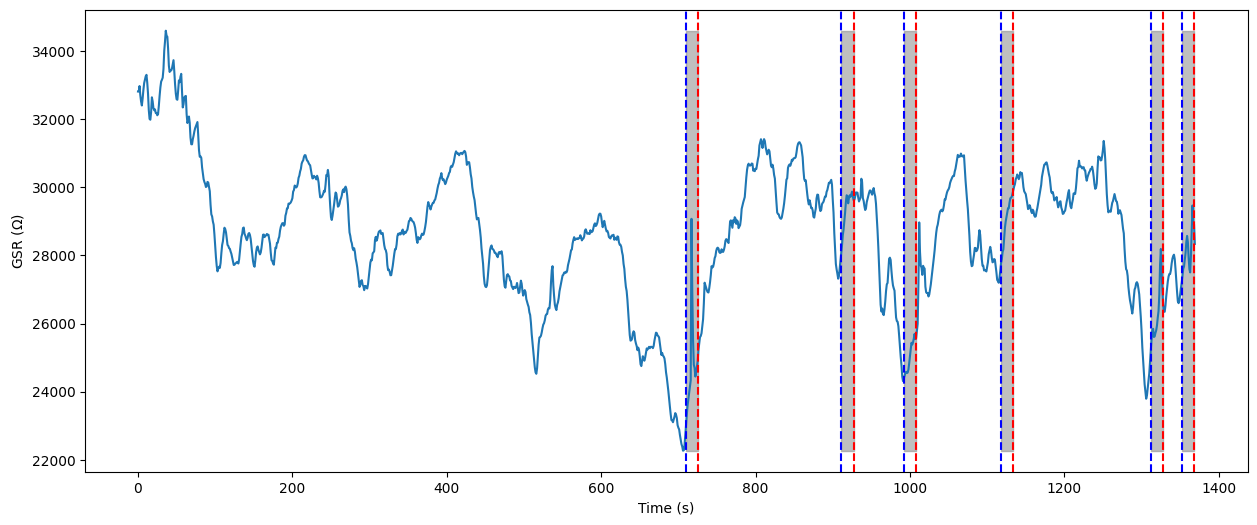

In [ ]:
ts = all_signals['match_10']['player_3']['gsr']['gsr'].values

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(ts)
for start, end in dtimes_windows:
    ax.axvline(x=start, color='blue', linestyle='--')  # Line at the start of the interval
    ax.axvline(x=end, color='red', linestyle='--')    # Line at the end of the interval
    ax.fill_betweenx(y=[ts.min(), ts.max()],x1=start, x2=end, color='gray', alpha=0.5)  # Fill between the lines

ax.set_xlabel('Time (s)')
ax.set_ylabel('GSR ($\Omega$)')


## Seperate real opponents vs not

In [ ]:
real = ['match_1','match_3','match_5','match_7','match_8','match_10','match_11','match_13','match_14','match_16','match_18','match_20']

In [ ]:
real_positive_class = []
real_negative_class = []
bot_positive_class  = []
bot_negative_class = []

for match_id in all_signals:
  if match_id in real:
  #print(match_id, all_signals[match_id].keys())
    for player in all_signals[match_id]:
      if 'eeg_power' in all_signals[match_id][player].keys():
        #print(match_id, player,all_signals[match_id][player].keys())
        train_data =get_windows(all_signals[match_id][player],time_delta = 4,under_sample = True)
        real_positive_class.append(train_data[0])
        real_negative_class.append(train_data[1])
  else:
    for player in all_signals[match_id]:
      if 'eeg_power' in all_signals[match_id][player].keys():
        #print(match_id, player,all_signals[match_id][player].keys())
        train_data =get_windows(all_signals[match_id][player],time_delta = 4,under_sample = True)
        bot_positive_class.append(train_data[0])
        bot_negative_class.append(train_data[1])


In [ ]:
signals = ['eeg', 'gsr', 'hr']
real_pos_total = {'eeg' : 0, 'gsr' : 0, 'hr' : 0}
for match_player in real_positive_class:
  #print(k, len(positive_class[0][k])
  real_pos_total['eeg'] += len(match_player['eeg'])
  real_pos_total['gsr'] += len(match_player['gsr'])
  real_pos_total['hr'] += len(match_player['hr'])
  # for j in positive_class[0][k]:
  #   print(len(j))
real_pos_total

{'eeg': 402, 'gsr': 402, 'hr': 402}

In [ ]:
real_neg_total = {'eeg' : 0, 'gsr' : 0, 'hr' : 0}
for match_player in real_negative_class:
  #print(k, len(positive_class[0][k]))
  real_neg_total['eeg'] += len(match_player['eeg'])
  real_neg_total['gsr'] += len(match_player['gsr'])
  real_neg_total['hr'] += len(match_player['hr'])
real_neg_total

{'eeg': 402, 'gsr': 402, 'hr': 402}

### Generative positive class

### Real

In [ ]:
# min-max scaling
mean = eeg_combined_array.mean(axis=(0,1))
std = eeg_combined_array.std(axis=(0,1))
min = eeg_combined_array.min(axis=(0,1))
max = eeg_combined_array.max(axis=(0,1))
median = np.median(eeg_combined_array, axis=(0,1))
quantile25 = np.quantile(eeg_combined_array, 0.25, axis=(0,1))
quantile75 = np.quantile(eeg_combined_array, 0.75, axis=(0,1))
iqr = quantile75 - quantile25

bands = ['theta','alpha','betaL','betaH','gamma']
group_bands = []
for b in bands:
  l = []
  for c in cols:
    if b in c:
      l.append(c)
  group_bands.append(l)

positive_new_features = []
for collection in real_positive_class:
  for example in collection['eeg']:
    ex_features = []
    #np_array = example.to_numpy()
    example = (example - median)/iqr
    #np_array_robust_T = np_array_robust.T
    for band in group_bands:
      #print(type(ex['eeg']))
      band_i = example[band].values.flatten()
      band_mean = np.mean(band_i)
      band_max = np.max(band_i)
      band_min = np.min(band_i)
      #print(band_mean, band_max, band_min)
      ex_features.extend([band_mean,band_max,band_min])
    positive_new_features.append(ex_features)
positive_new_features = np.array(positive_new_features)

negative_new_features = []
for collection in real_negative_class:
  for example in collection['eeg']:
    ex_features = []
    example = (example - median)/iqr
    for band in group_bands:
      #print(type(ex['eeg']))
      band_i = example[band].values.flatten()
      band_mean = np.mean(band_i)
      band_max = np.max(band_i)
      band_min = np.min(band_i)
      #print(band_mean, band_max, band_min)
      ex_features.extend([band_mean,band_max,band_min])
    negative_new_features.append(ex_features)
negative_new_features = np.array(negative_new_features)

np.savetxt("real_only/positive_eeg.csv", positive_new_features, delimiter=",")
np.savetxt("real_only/negative_eeg.csv", negative_new_features, delimiter=",")

In [ ]:
print('n files in folder before: ')
len(os.listdir('real_only/eeg_images/positive_class'))



n files in folder before: 


0

In [ ]:
X_eeg = []
X_gsr = []
X_hr = []
# class is a list of dictionaries
for sample in real_positive_class:
  for signal in sample:
    #print(signal, len(sample[signal]))
    if signal == 'eeg':
      X_eeg.append(sample[signal])
    if signal == 'gsr':
      X_gsr.append(sample[signal])
    if signal == 'hr':
      X_hr.append(sample[signal])

path = 'real_only/eeg_images'

_class = 'positive_class'
eeg_to_image(X_eeg,path,_class,eeg_combined_array,"positive")

In [ ]:
print('n files in folder after, should match pro_pos_total for gsr: ')
print(real_pos_total['eeg'])
len(os.listdir('real_only/eeg_images/positive_class/'))

n files in folder after, should match pro_pos_total for gsr: 
402


402

In [ ]:
print('n files in folder before: ')
len(os.listdir('real_only/gsr/positive_class'))

n files in folder before: 


0

In [ ]:
for i,dat in enumerate(X_gsr):
  #print(len(i))
  for j, df in enumerate(dat):
    df = df.reset_index(drop = True).T
    df.to_csv(f'real_only/gsr/positive_class/match_{i}_event_{j}.csv')

In [ ]:
print('n files in folder after, should match real_pos_total for gsr: ')
print(real_pos_total['gsr'])
len(os.listdir('real_only/gsr/positive_class/'))

n files in folder after, should match real_pos_total for gsr: 
402


402

In [ ]:
print('n files in folder before: ')
len(os.listdir('real_only/hr/positive_class'))

n files in folder before: 


0

In [ ]:
for i,dat in enumerate(X_hr):
  for j, df in enumerate(dat):
    hr_vals = pd.DataFrame(df['heart_rate'].reset_index(drop = True)).T
    hr_vals.to_csv(f'/content/drive/MyDrive/Tilburg/Masters CSAI/Year 1 - Semester 2/Brain Computer Interfacing/BCI Project/training data/context_4/real_only/hr/positive_class/match_{i}_event_{j}.csv')

In [ ]:
print('n files in folder after, should match pro_pos_total for gsr: ')
print(real_pos_total['hr'])
len(os.listdir('/content/drive/MyDrive/Tilburg/Masters CSAI/Year 1 - Semester 2/Brain Computer Interfacing/BCI Project/training data/context_4/real_only/hr/positive_class/'))

n files in folder after, should match pro_pos_total for gsr: 
402


402

### Bot

In [ ]:
X_eeg = []
X_gsr = []
X_hr = []
# class is a list of dictionaries
for sample in bot_positive_class:
  for signal in sample:
    if signal == 'eeg':
      X_eeg.append(sample[signal])
    if signal == 'gsr':
      X_gsr.append(sample[signal])
    if signal == 'hr':
      X_hr.append(sample[signal])

path = 'bot_only/eeg_images'
_class = 'positive_class'
eeg_to_image(X_eeg,path,_class)

In [ ]:
for i,dat in enumerate(X_gsr):
  #print(len(i))
  for j, df in enumerate(dat):
    df = df.reset_index(drop = True).T
    df.to_csv(f'bot_only/gsr/positive_class/match_{i}_event_{j}.csv')

In [ ]:

for i,dat in enumerate(X_hr):
  for j, df in enumerate(dat):
    hr_vals = pd.DataFrame(df['heart_rate'].reset_index(drop = True)).T
    hr_vals.to_csv(f'bot_only/hr/positive_class/match_{i}_event_{j}.csv')

### Get negative

### Real

In [ ]:
print('n files in folder before: ')
len(os.listdir('real_only/eeg_images/negative_class'))

n files in folder before: 


0

In [ ]:
X_eeg = []
X_gsr = []
X_hr = []
# class is a list of dictionaries
for sample in real_negative_class:
  for signal in sample:
    if signal == 'eeg':
      X_eeg.append(sample[signal])
    if signal == 'gsr':
      X_gsr.append(sample[signal])
    if signal == 'hr':
      X_hr.append(sample[signal])

path = 'real_only/eeg_images'

_class = 'negative_class'
eeg_to_image(X_eeg,path,_class,eeg_combined_array,"negative")



In [ ]:
print('n files in folder after, should match real_neg_total for eeg: ')
print(real_neg_total['eeg'])
len(os.listdir('real_only/eeg_images/negative_class/'))

n files in folder after, should match real_neg_total for eeg: 
402


402

In [ ]:
print('n files in folder before: ')
len(os.listdir('real_only/gsr/negative_class'))

n files in folder before: 


0

In [ ]:
for i,dat in enumerate(X_gsr):
  #print(len(i))
  for j, df in enumerate(dat):
    df = df.reset_index(drop = True).T
    df.to_csv(f'real_only/gsr/negative_class/match_{i}_event_{j}.csv')

In [ ]:
print('n files in folder after, should match real_neg_total for gsr: ')
print(real_neg_total['gsr'])
len(os.listdir('real_only/gsr/negative_class/'))

n files in folder after, should match real_neg_total for gsr: 
402


402

In [ ]:
print('n files in folder before: ')
len(os.listdir('real_only/hr/negative_class'))

n files in folder before: 


0

In [ ]:
for i,dat in enumerate(X_hr):
  #print(len(i))
  for j, df in enumerate(dat):
    #print(df)hr
    hr_vals = pd.DataFrame(df['heart_rate'].reset_index(drop = True)).T
    #hr_vals[8] = 1
    #print(hr_vals)
    hr_vals.to_csv(f'real_only/hr/negative_class/match_{i}_event_{j}.csv')

In [ ]:
print('n files in folder after, should match real_neg_total for gsr: ')
print(real_neg_total['hr'])
len(os.listdir('real_only/hr/negative_class/'))

n files in folder after, should match real_neg_total for gsr: 
402


402

### Bot

In [ ]:
X_eeg = []
X_gsr = []
X_hr = []
# class is a list of dictionaries
for sample in bot_negative_class:
  for signal in sample:
    #print(signal, len(sample[signal]))
    if signal == 'eeg':
      X_eeg.append(sample[signal])
    if signal == 'gsr':
      X_gsr.append(sample[signal])
    if signal == 'hr':
      X_hr.append(sample[signal])

path = 'bot_only/eeg_images'
_class = 'negative_class'
eeg_to_image(X_eeg,path,_class)

In [ ]:
for i,dat in enumerate(X_gsr):
  for j, df in enumerate(dat):
    df = df.reset_index(drop = True).T
    df.to_csv(f'bot_only/gsr/negative_class/match_{i}_event_{j}.csv')

In [ ]:
for i,dat in enumerate(X_hr):
  for j, df in enumerate(dat):
    hr_vals = pd.DataFrame(df['heart_rate'].reset_index(drop = True)).T
    hr_vals.to_csv(f'bot_only/hr/negative_class/match_{i}_event_{j}.csv')

# Validatino : Random forest and gradient boost on new EEG features

## All combined

In [ ]:
pos_class = pd.read_csv('all_combined/positive_eeg.csv',header = None)
neg_class = pd.read_csv('all_combined/negative_eeg.csv',header = None)

In [ ]:
## Code generated by GPT4/0

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, f1_score

# Assuming pos_class and neg_class are numpy arrays
# Combining the classes into a single dataset
X = np.vstack((pos_class, neg_class))
y = np.hstack((np.ones(pos_class.shape[0]), np.zeros(neg_class.shape[0])))

# Defining the parameter grid for Grid Search
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

gb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Initializing the models
rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)

# # Performing Grid Search with cross-validation
rf_grid_search = GridSearchCV(rf, rf_param_grid, cv=10, scoring='f1')
gb_grid_search = GridSearchCV(gb, gb_param_grid, cv=10, scoring='f1')

# Fitting the models
rf_grid_search.fit(X, y)
gb_grid_search.fit(X, y)

# Best models
best_rf = rf_grid_search.best_estimator_
best_gb = gb_grid_search.best_estimator_

# Cross-validation scores
rf_cv_scores = cross_val_score(best_rf, X, y, cv=10, scoring='f1')
gb_cv_scores = cross_val_score(best_gb, X, y, cv=10, scoring='f1')

# Printing results
print(f"Random Forest Classifier F1 Score: {rf_cv_scores.mean():.2f} ± {rf_cv_scores.std():.2f}")
print(f"Gradient Boosting Classifier F1 Score: {gb_cv_scores.mean():.2f} ± {gb_cv_scores.std():.2f}")

# Printing best parameters
print("Best parameters for Random Forest:")
print(rf_grid_search.best_params_)

print("Best parameters for Gradient Boosting:")
print(gb_grid_search.best_params_)

# Accuracy scores (optional)
rf_acc_scores = cross_val_score(best_rf, X, y, cv=10, scoring='accuracy')
gb_acc_scores = cross_val_score(best_gb, X, y, cv=10, scoring='accuracy')

print(f"Random Forest Classifier Accuracy: {rf_acc_scores.mean():.2f} ± {rf_acc_scores.std():.2f}")
print(f"Gradient Boosting Classifier Accuracy: {gb_acc_scores.mean():.2f} ± {gb_acc_scores.std():.2f}")


## Real only

In [ ]:
pos_class = pd.read_csv('/content/drive/MyDrive/Tilburg/Masters CSAI/Year 1 - Semester 2/Brain Computer Interfacing/BCI Project/training data/context_4/real_only/positive_eeg.csv',header = None)
neg_class = pd.read_csv('/content/drive/MyDrive/Tilburg/Masters CSAI/Year 1 - Semester 2/Brain Computer Interfacing/BCI Project/training data/context_4/real_only/negative_eeg.csv',header = None)

In [ ]:
## Code generated by GPT4/0

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, f1_score

# Assuming pos_class and neg_class are numpy arrays
# Combining the classes into a single dataset
X = np.vstack((pos_class, neg_class))
y = np.hstack((np.ones(pos_class.shape[0]), np.zeros(neg_class.shape[0])))

# Defining the parameter grid for Grid Search
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

gb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Initializing the models
rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)

# # Performing Grid Search with cross-validation
rf_grid_search = GridSearchCV(rf, rf_param_grid, cv=10, scoring='f1')
gb_grid_search = GridSearchCV(gb, gb_param_grid, cv=10, scoring='f1')

# Fitting the models
rf_grid_search.fit(X, y)
gb_grid_search.fit(X, y)

# Best models
best_rf = rf_grid_search.best_estimator_
best_gb = gb_grid_search.best_estimator_

# Cross-validation scores
rf_cv_scores = cross_val_score(best_rf, X, y, cv=10, scoring='f1')
gb_cv_scores = cross_val_score(best_gb, X, y, cv=10, scoring='f1')

# Printing results
print(f"Random Forest Classifier F1 Score: {rf_cv_scores.mean():.2f} ± {rf_cv_scores.std():.2f}")
print(f"Gradient Boosting Classifier F1 Score: {gb_cv_scores.mean():.2f} ± {gb_cv_scores.std():.2f}")

# Printing best parameters
print("Best parameters for Random Forest:")
print(rf_grid_search.best_params_)

print("Best parameters for Gradient Boosting:")
print(gb_grid_search.best_params_)

# Accuracy scores (optional)
rf_acc_scores = cross_val_score(best_rf, X, y, cv=10, scoring='accuracy')
gb_acc_scores = cross_val_score(best_gb, X, y, cv=10, scoring='accuracy')

print(f"Random Forest Classifier Accuracy: {rf_acc_scores.mean():.2f} ± {rf_acc_scores.std():.2f}")
print(f"Gradient Boosting Classifier Accuracy: {gb_acc_scores.mean():.2f} ± {gb_acc_scores.std():.2f}")
